# TSI Classifier, transfer learning

In this document I'll illustrate the workflow of training a convolutional neural network trough the process of transfer learning. The structure of the document is as follows:

* Importing packages
* Import dataset
* Importing base model
* Create new model head 
* Train model (transfer learning)
* Test model on test set
* Train model (fine-tuning)
* Test model on test set
* Predict on single image
* Predict on large raw datasets


## Importing packages

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
from PIL import Image
import pathlib
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix

from predict_functions import MassPredictor, FilterPredictions, ExportFilteredFiles, TrainingProgress, PredictImage, ShowPrediction

## Import dataset

In [10]:
def LoadTrainAndValData(data_path, batch_size=32 ,img_height=352,img_width=288,num_classes=3,seed=111):
    data_dir = pathlib.Path(data_path) 

    train_datagen = ImageDataGenerator( # Choose how to augment the training data. Too much augmentation reduces performance,
        brightness_range = (0.5, 1.5),  # too little augmentation might lead to quicker overfitting 
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range = 360,           # Rotation might be too heavy augmentation and should probably be used together with
        zoom_range=[1.10, 1.10],        # zoom (out) to avoid cropping out the important parts of the image
        validation_split=0.2)           # Ratio of dataset which is reserved for validation (not trained on)

    val_datagen = ImageDataGenerator(   # Validation data should not be augmented
        validation_split=0.2)           # Ratio of dataset which is reserved for validation (not trained on)

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        shuffle = True,                 # It is important to shuffle training data
        seed = seed,                    # Seed should be the same on the two generators to make sure that validation and
        batch_size=batch_size,          # training datasets does not get mixed up
        class_mode='categorical',
        subset = 'training')

    validation_generator = val_datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        shuffle = True,
        seed = seed,
        batch_size=batch_size,
        class_mode='categorical',
        subset = 'validation')
    return train_generator, validation_generator

In [11]:
data_path = 'data/training'
batch_size = 32
img_height = 352
img_width = 288
num_classes = 3    # Number of classes, e.g. 'fogbow/iceoptics/no_optics'
seed = 3131

train_generator, validation_generator = LoadTrainAndValData(data_path, batch_size, img_height, img_width, num_classes, seed)

Found 176 images belonging to 3 classes.
Found 42 images belonging to 3 classes.


### Visualising augmentation

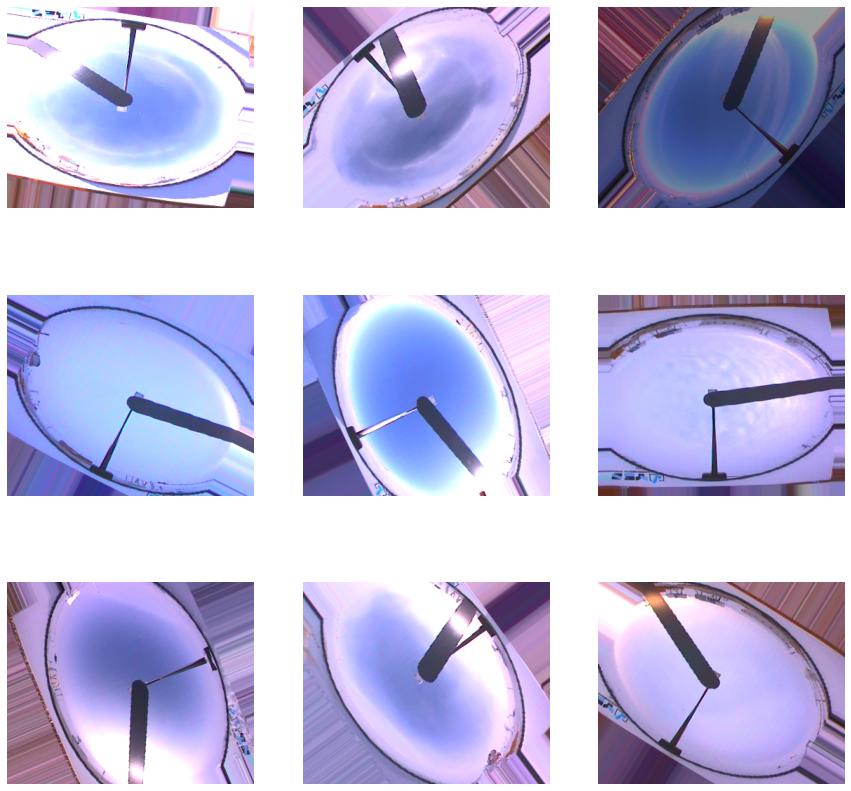

In [12]:
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = next(train_generator)[0][0].astype('uint8')
    ax.imshow(image)
    ax.axis('off')

## Importing base model

In [13]:
# imports Xception model trained on ImageNet but without the classifier 
base_model = Xception(weights='imagenet',include_top=False) 
base_model.trainable = False

# base_model.summary() # include to visualise layers

## Create new model head

In [14]:
i=keras.Input(shape=(None, None, 3))    # Defining input shape (None=any)
x=preprocess_input(i)                     # Preprocessing input to a Xception-ready format
x=base_model(x, training=False)           # Adding Xception base model
x=layers.GlobalAveragePooling2D()(x)      # Pooling layer
x=layers.Dense(1024,activation='relu')(x) # Dense neutral layer
x=layers.Dropout(0.2)(x)                  # Dropout layer (deactivates 20% of neutrons to avoid overfitting)
x=layers.Dense(1024,activation='relu')(x) # Dense layer
x=layers.Dropout(0.2)(x)                  # Dropout layer
x=layers.Dense(num_classes,activation='softmax')(x) # Final dense layer 
# OBS: The size of this layer must equal the number of classes!

model=Model(inputs=i,outputs=x)           # Defining model

#model.summary()

model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=[keras.metrics.CategoricalAccuracy()])  # Compiling model and choosing optimizer 

## Train model (transfer learning)

In [15]:
# Train model

epochs = 5                                       # Number of training rounds (max ≈ 50 should be sufficient) 
checkpoint_path = "checkpoints/transfer_{epoch}.h5"  # Where to save checkpoints that can be resumed from
batch_size = 32

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_categorical_accuracy', # Choosing which checkpoints to save
                             verbose=1, save_best_only=True, mode='max')

history = model.fit(      # This function will train the model
  train_generator,
  steps_per_epoch=train_generator.samples // batch_size,
  epochs=epochs,
  validation_data=validation_generator,
  validation_steps=validation_generator.samples // batch_size,
  callbacks = [checkpoint] # Comment out if you don't want checkpoints
)

Epoch 1/5
5/5 [==============================] - 19s 3s/step - loss: 1.4750 - categorical_accuracy: 0.3562 - val_loss: 1.1264 - val_categorical_accuracy: 0.3125

Epoch 00001: val_categorical_accuracy improved from -inf to 0.31250, saving model to checkpoints/transfer_1.h5


/opt/tljh/user/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
5/5 [==============================] - 13s 3s/step - loss: 1.0292 - categorical_accuracy: 0.4514 - val_loss: 1.0428 - val_categorical_accuracy: 0.4688

Epoch 00002: val_categorical_accuracy improved from 0.31250 to 0.46875, saving model to checkpoints/transfer_2.h5
Epoch 3/5
5/5 [==============================] - 15s 3s/step - loss: 0.9718 - categorical_accuracy: 0.5063 - val_loss: 0.9454 - val_categorical_accuracy: 0.4688

Epoch 00003: val_categorical_accuracy did not improve from 0.46875
Epoch 4/5
5/5 [==============================] - 14s 3s/step - loss: 0.8221 - categorical_accuracy: 0.6319 - val_loss: 0.9777 - val_categorical_accuracy: 0.4688

Epoch 00004: val_categorical_accuracy did not improve from 0.46875
Epoch 5/5
5/5 [==============================] - 13s 3s/step - loss: 0.8099 - categorical_accuracy: 0.7014 - val_loss: 0.7993 - val_categorical_accuracy: 0.5312

Epoch 00005: val_categorical_accuracy improved from 0.46875 to 0.53125, saving model to checkpoints/tran

### Visualise training progress

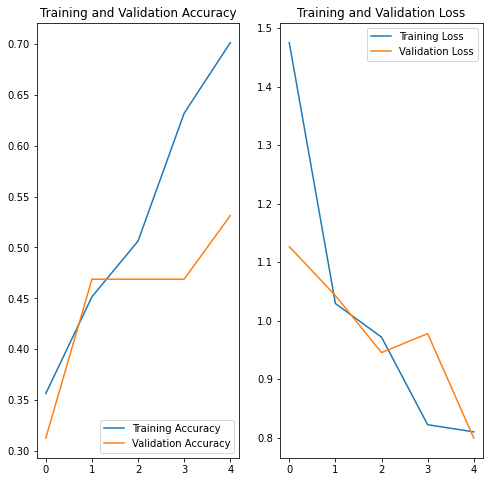

In [16]:
TrainingProgress(history, epochs,'training_progress/transfer.png')

## Test model on test set
### Importing test dataset

In [17]:
data_dir = 'data/test'
img_width = 288
img_height = 352
batch_size = 32

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        shuffle = False,
        batch_size=batch_size,
        class_mode='categorical')

Found 214 images belonging to 3 classes.


### Creating classification report

In [18]:
batch_size = 32
Y_pred = model.predict(test_generator, test_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = ['Fogbow', 'Iceoptics', 'No optics']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Fogbow       1.00      0.08      0.15        60
   Iceoptics       0.63      0.42      0.50        65
   No optics       0.44      0.82      0.57        89

    accuracy                           0.49       214
   macro avg       0.69      0.44      0.41       214
weighted avg       0.65      0.49      0.43       214



## Train model (fine-tuning)

During fine-tuning, the whole model will be trainable. However, as there is a high risk of quick overfitting, the learning rate will be very low and the training will only run for a few epochs. The validation accuracy should be closely monitored to decide when to stop the training.

In [19]:
base_model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',
              metrics=[keras.metrics.CategoricalAccuracy()])  # Setting low learning rate

epochs = 5                                         # Set to a few rounds (max 20-ish)
checkpoint_path = "checkpoints/finetune_{epoch}.h5"
batch_size = 32

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_categorical_accuracy',
                             verbose=1, save_best_only=True, mode='max')

history = model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples // batch_size,
  epochs=epochs,
  validation_data=validation_generator,
  validation_steps=validation_generator.samples // batch_size,
  callbacks = [checkpoint] # Comment out if you don't want checkpoints
)

Epoch 1/5
5/5 [==============================] - 61s 12s/step - loss: 0.6442 - categorical_accuracy: 0.7569 - val_loss: 0.8912 - val_categorical_accuracy: 0.5625

Epoch 00001: val_categorical_accuracy improved from -inf to 0.56250, saving model to checkpoints/finetune_1.h5


/opt/tljh/user/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
5/5 [==============================] - 54s 10s/step - loss: 0.5905 - categorical_accuracy: 0.7917 - val_loss: 0.9020 - val_categorical_accuracy: 0.5625

Epoch 00002: val_categorical_accuracy did not improve from 0.56250
Epoch 3/5
5/5 [==============================] - 55s 10s/step - loss: 0.6365 - categorical_accuracy: 0.7569 - val_loss: 0.8462 - val_categorical_accuracy: 0.6562

Epoch 00003: val_categorical_accuracy improved from 0.56250 to 0.65625, saving model to checkpoints/finetune_3.h5
Epoch 4/5
5/5 [==============================] - 55s 11s/step - loss: 0.5125 - categorical_accuracy: 0.8194 - val_loss: 0.8684 - val_categorical_accuracy: 0.5312

Epoch 00004: val_categorical_accuracy did not improve from 0.65625
Epoch 5/5
5/5 [==============================] - 54s 10s/step - loss: 0.5406 - categorical_accuracy: 0.7639 - val_loss: 0.8497 - val_categorical_accuracy: 0.6250

Epoch 00005: val_categorical_accuracy did not improve from 0.65625


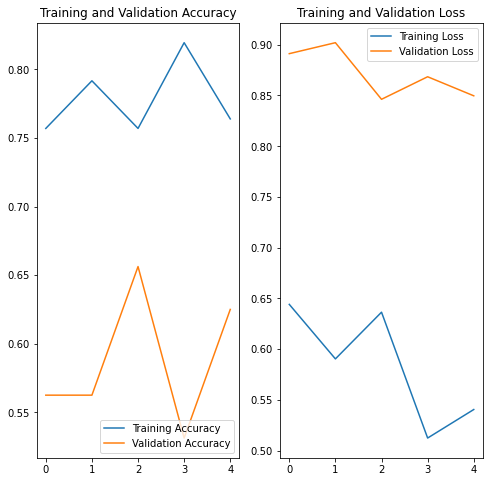

In [20]:
TrainingProgress(history, epochs,'training_progress/finetune.png')

In [21]:
batch_size = 32
Y_pred = model.predict(test_generator, test_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = ['Fogbow', 'Iceoptics', 'No optics']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Fogbow       1.00      0.08      0.15        60
   Iceoptics       0.63      0.42      0.50        65
   No optics       0.44      0.82      0.57        89

    accuracy                           0.49       214
   macro avg       0.69      0.44      0.41       214
weighted avg       0.65      0.49      0.43       214



### Save model

Now you'd probably like to save your model, including weights:

In [22]:
model.save('saved_model/finetune')

/opt/tljh/user/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: saved_model/finetune/assets


To load a model again, run:

In [4]:
#model = tf.keras.models.load_model('saved_model/finetune') 

## Predict on single image

This image most likely belongs to 
 no_optics with a 39.83 % confidence.


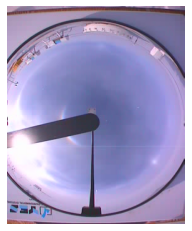

In [5]:
predic_dir = 'data/examples'
path = os.path.join(predic_dir, os.listdir(predic_dir)[1])
prediction=PredictImage(path, model)
ShowPrediction(path, prediction,train_generator.class_indices)

## Predict on large raw datasets

This hefty block of code does the following:
* Takes compressed TSI-files and predict all files, outputs to CSV file
* Read CSV files and filters out the ones with the required confidence
* Moving the filtered images to a similar file structure as the training set 

This code is tailored for the TSI output as published on their database in order to minimise manual preprocessing. The function could possibly be directed directly to the server where the data is released, however it is not optimised for this and downloading the data first is therefore recommended. 

The CSV files are structured as follows:

| Time (YYYYMMDDHHMMSS) | Prediction | Prediction confidence | Fogbow confidence | Iceoptics confidence | No optics confidence | 
| ------------- |:-------------:| :-----:| :------: | :------: | :-------: |
| 20140611064600  | 2 | 0.563424 | 0.243244 | 0.193332 | 0.563424 |

The class indicies should be 0: fogbow, 1: iceoptics, 2: no_optics, but can be confirmed by running:


In [23]:
train_generator.class_indices

{'fogbow': 0, 'iceoptics': 1, 'no_optics': 2}

### Applying predictions on large datasets

In [ ]:
# All following paths should already exist before running commands

tar_files_path = "data/to_be_predicted" # path to input tar files for prediction
predictions_CSV_path = "predictions/predictions_CSV" # path where the output CSV files will be placed
predicted_path = 'predictions/predicted_files' # path where the images will be copied to in labeled folder structure

In [6]:
# options: tar_files_path, predictions_path, model, excludelist=[]
# excludelist can be applied to exclude certain datasets or non-data files
MassPredictor(tar_files_path, predictions_CSV_path, model) 

Predicting on 1 dataset(s): 
 ['tsi20140723.tar.gz']
1 / 1 : Predicting  tsi20140723.tar.gz


Now you have a CSV file with the predictions from all tar files in the tar_files_path-folder

In [7]:
# options: predicted_path, lower_limit, higher_limit=1.0, excludelist=[]
fog, ice, no = FilterPredictions(predictions_CSV_path,0.3)

Number of detections with threshold between 30.0 % and  100.0 %: 
Fogbows: 262 
Ice optics: 0 
Nothing: 1178


You now have lists of all filenames from the CSV files in the predicted_path-folder of the different categories, within the threshold defined

In [8]:
# options: tar_files_path, export_path, fog_detections, ice_detections, no_detections
ExportFilteredFiles(tar_files_path, predicted_path, fog, ice, no)

no_detections done
ice_detections done
fog_detections done


You now have a folder (export_path) with all the photos from FilterPredictions, categorised according to predicted label.

This concludes this guide.